# Fuzzy Logic Quality Control

### Example of the fuzzy approach to quality control

The source code of this ipython notebook, as well as other examples, can be found in the documentation of CoTeDe (http://cotede.castelao.net)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from cotede.fuzzy import membership_functions as fuzz
from cotede.fuzzy.defuzz import defuzz
from cotede.utils import load_cfg

## Introduction

Let's assume a set of measurements $x$ that could be temperature measurements from an Argo or salinity from a CTD. 
The goal here is to evaluate the quality of each measurement ($x_i$) using Fuzzy Logic.
We would like to evaluate each measurement $x_i$ not only by the value itself, but from different perspectives, like how similar is that measurement to the climatology? We'll call each one of this perspectives as a feature, and will construct a multi-dimensional evaluation system. 

The features we'll use here are:

- Spike
- Climatology
- Gradient

We'll assume that the measurement $x_i$ resulted in the following values:

In [3]:
spike = 1.0
clim = 5.4
grad = 0.9

## Membership Functions

The first step to do is to define the membership functions on 3 levels of uncertainty: low, medium and high, for each feature. 

In [4]:
cfg = load_cfg('fuzzylogic')['variables']['sea_water_temperature']
cfg.keys()

odict_keys(['spike', 'woa_normbias', 'gradient', 'fuzzylogic'])

An example of membership function parameters. The fuzzy set 'low' for feature 'spike' is:

In [5]:
cfg['fuzzylogic']['features']['spike']

OrderedDict([('weight', 1),
             ('low', [0.07, 0.2]),
             ('medium', [0.07, 0.2, 2, 6]),
             ('high', [2, 6])])

In [6]:
data = {}

data['x_spike'] = np.linspace(0, 7, 200)
data['x_clim'] = np.linspace(0, 10, 200)
data['x_grad'] = np.linspace(0, 6, 200)
x_QC  = np.linspace(0.0, 1.0, 200)

# Generate fuzzy membership functions
data['spike_lo'] = fuzz.zmf(data['x_spike'], cfg['fuzzylogic']['features']['spike']['low']['params'])
data['spike_md'] = fuzz.trapmf(data['x_spike'], cfg['fuzzylogic']['features']['spike']['medium']['params'])
data['spike_hi'] = fuzz.smf(data['x_spike'], cfg['fuzzylogic']['features']['spike']['high']['params'])

data['clim_lo'] = fuzz.zmf(data['x_clim'], cfg['fuzzylogic']['features']['woa_normbias']['low']['params'])
data['clim_md'] = fuzz.trapmf(data['x_clim'], cfg['fuzzylogic']['features']['woa_normbias']['medium']['params'])
data['clim_hi'] = fuzz.smf(data['x_clim'], cfg['fuzzylogic']['features']['woa_normbias']['high']['params'])

data['grad_lo'] = fuzz.zmf(data['x_grad'], cfg['fuzzylogic']['features']['gradient']['low']['params'])
data['grad_md'] = fuzz.trapmf(data['x_grad'], cfg['fuzzylogic']['features']['gradient']['medium']['params'])
data['grad_hi'] = fuzz.smf(data['x_grad'], cfg['fuzzylogic']['features']['gradient']['high']['params'])

QC_lo = fuzz.trimf(x_QC, [0.0, 0.225, 0.45])
QC_md = fuzz.trimf(x_QC, [0.275, 0.5, 0.725])
QC_hi = fuzz.trimf(x_QC, [0.55, 0.775, 1.0])
QC_hi = fuzz.trapmf(x_QC, [0.55, 0.775, 1.0, 1e30])

Let's visualize the membership functions, and the input features being evaluated.

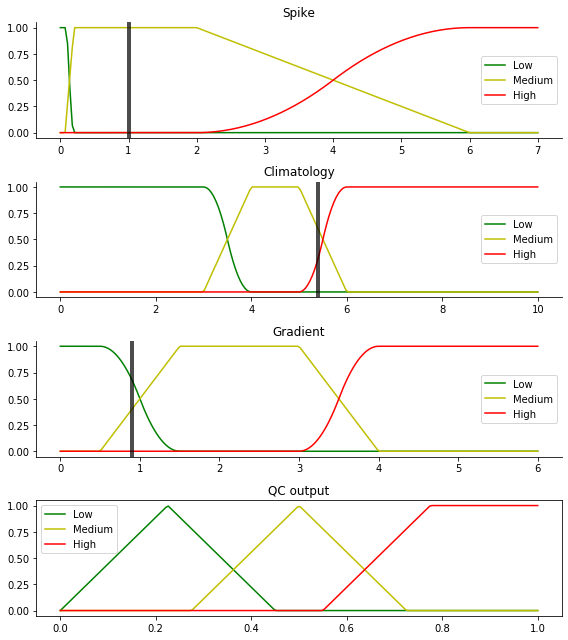

In [7]:
# Visualize these universes and membership functions
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, figsize=(8, 9))

ax0.plot(data['x_spike'], data['spike_lo'], 'g', linewidth=1.5, label='Low')
ax0.plot(data['x_spike'], data['spike_md'], 'y', linewidth=1.5, label='Medium')
ax0.plot(data['x_spike'], data['spike_hi'], 'r', linewidth=1.5, label='High')
ax0.axvline(spike, color='k', linewidth=4, alpha=0.7)
ax0.set_title('Spike')
ax0.legend()

ax1.plot(data['x_clim'], data['clim_lo'], 'g', linewidth=1.5, label='Low')
ax1.plot(data['x_clim'], data['clim_md'], 'y', linewidth=1.5, label='Medium')
ax1.plot(data['x_clim'], data['clim_hi'], 'r', linewidth=1.5, label='High')
ax1.axvline(clim, color='k', linewidth=4, alpha=0.7)
ax1.set_title('Climatology')
ax1.legend()

ax2.plot(data['x_grad'], data['grad_lo'], 'g', linewidth=1.5, label='Low')
ax2.plot(data['x_grad'], data['grad_md'], 'y', linewidth=1.5, label='Medium')
ax2.plot(data['x_grad'], data['grad_hi'], 'r', linewidth=1.5, label='High')
ax2.axvline(grad, color='k', linewidth=4, alpha=0.7)
ax2.set_title('Gradient')
ax2.legend()

ax3.plot(x_QC, QC_lo, 'g', linewidth=1.5, label='Low')
ax3.plot(x_QC, QC_md, 'y', linewidth=1.5, label='Medium')
ax3.plot(x_QC, QC_hi, 'r', linewidth=1.5, label='High')
ax3.set_title('QC output')
ax3.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

### Fuzzy Membership

In [8]:
spike_level_lo = np.interp(spike, data['x_spike'], data['spike_lo'])
spike_level_md = np.interp(spike, data['x_spike'], data['spike_md'])
spike_level_hi = np.interp(spike, data['x_spike'], data['spike_hi'])

print("Spike: %s" % spike)
print("Low uncert.: %.2f, Medium uncert.: %.2f, High uncert.: %.2f" %
      (spike_level_lo, spike_level_md, spike_level_hi))

clim_level_lo = np.interp(clim, data['x_clim'], data['clim_lo'])
clim_level_md = np.interp(clim, data['x_clim'], data['clim_md'])
clim_level_hi = np.interp(clim, data['x_clim'], data['clim_hi'])

print("")
print("Climatology bias: %s" % clim)
print("Low uncert.: %.2f, Medium uncert.: %.2f, High uncert.: %.2f" %
      (clim_level_lo, clim_level_md, clim_level_hi))

grad_level_lo = np.interp(grad, data['x_grad'], data['grad_lo'])
grad_level_md = np.interp(grad, data['x_grad'], data['grad_md'])
grad_level_hi = np.interp(grad, data['x_grad'], data['grad_hi'])

print("")
print("Gradient: %s" % grad)
print("Low uncert.: %.2f, Medium uncert.: %.2f, High uncert.: %.2f" %
      (grad_level_lo, grad_level_md, grad_level_hi))

Spike: 1.0
Low uncert.: 0.00, Medium uncert.: 1.00, High uncert.: 0.00

Climatology bias: 5.4
Low uncert.: 0.00, Medium uncert.: 0.60, High uncert.: 0.32

Gradient: 0.9
Low uncert.: 0.68, Medium uncert.: 0.40, High uncert.: 0.00


##  Fuzzy Rules

Now we take our rules and apply them.

### Low uncertainty

In [9]:
active_rule1 = np.mean((spike_level_lo, clim_level_lo, grad_level_lo), axis=0)
print("active rule low: %s, %s, %s -> %s" %
      (spike_level_lo, clim_level_lo, grad_level_lo, active_rule1))

# Now we apply this by clipping the top off the corresponding output
# membership function with `np.fmin`
QC_activation_lo = np.fmin(active_rule1, QC_lo)
#print("QC_activation_lo: %s" % QC_activation_lo)

active rule low: 0.0, 0.0, 0.6797681876720284 -> 0.22658939589067614


### Medium uncertainty

In [10]:
active_rule2 = np.mean((spike_level_md, clim_level_md, grad_level_md), axis=0)
print("active rule medium: %s, %s, %s -> %s" %
      (spike_level_md, clim_level_md, grad_level_md, active_rule2))

#QC_activation_md = np.fmin(clim_level_md, QC_md)
QC_activation_md = np.fmin(active_rule2, QC_md)
#print("QC_activation_md: %s" % QC_activation_md)

active rule medium: 1.0, 0.5999999999999996, 0.4 -> 0.6666666666666665


### High uncertainty

In [11]:
# The OR operator means we take the maximum of these.

active_rule3 = np.fmax(grad_level_hi, np.fmax(spike_level_hi, clim_level_hi))
print("active rule high: %s, %s, %s -> %s" %
      (spike_level_hi, clim_level_hi, grad_level_hi, active_rule3))

QC_activation_hi = np.fmin(active_rule3, QC_hi)
#print("QC_activation_hi: %s" % QC_activation_hi)

active rule high: 0.0, 0.32125451377490527, 0.0 -> 0.32125451377490527


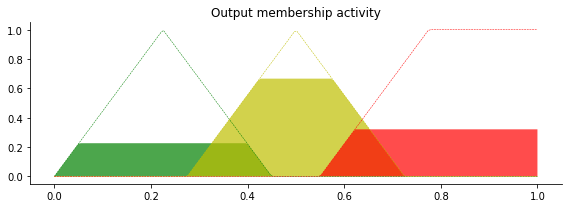

In [12]:
# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

QC0 = np.zeros_like(x_QC)

ax0.fill_between(x_QC, QC0, QC_activation_lo, facecolor='g', alpha=0.7, label='low')
ax0.plot(x_QC, QC_lo, 'g', linewidth=0.5, linestyle='--', )
ax0.fill_between(x_QC, QC0, QC_activation_md, facecolor='y', alpha=0.7, label='medium')
ax0.plot(x_QC, QC_md, 'y', linewidth=0.5, linestyle='--')
ax0.fill_between(x_QC, QC0, QC_activation_hi, facecolor='r', alpha=0.7, label='high')
ax0.plot(x_QC, QC_hi, 'r', linewidth=0.5, linestyle='--')
ax0.set_title('Output membership activity')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

## Defuzzifying

In [13]:
# Aggregate all three output membership functions together
aggregated = np.fmax(QC_activation_lo,
                     np.fmax(QC_activation_md, QC_activation_hi))

# Calculate defuzzified result
#QC = fuzz.defuzz(x_QC, aggregated, 'centroid')
QC = defuzz(x_QC, aggregated, 'bisector')
QC_activation = np.interp(QC, x_QC, aggregated)  # for plot

print("The QC was evaluated as: %.2f" % QC)

The QC was evaluated as: 0.53


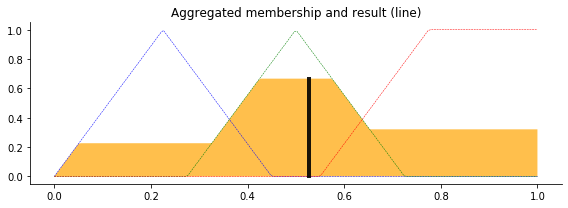

In [14]:
# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.plot(x_QC, QC_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.plot(x_QC, QC_md, 'g', linewidth=0.5, linestyle='--')
ax0.plot(x_QC, QC_hi, 'r', linewidth=0.5, linestyle='--')
ax0.fill_between(x_QC, QC0, aggregated, facecolor='Orange', alpha=0.7)
ax0.plot([QC, QC], [0, QC_activation], 'k', linewidth=4, alpha=0.9)
ax0.set_title('Aggregated membership and result (line)')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()